# Embeddings con LSTM



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import random
import matplotlib.pyplot as plt
# from itertools import chain
# from pprint import pprint
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
cd ../helpers/

C:\Users\Usuario.000\Documents\Facultad\Git\2020-2\APIT-2020-2\ProyectoFinal\helpers


In [3]:
import boletines

In [4]:
cd ../Embeddings/

C:\Users\Usuario.000\Documents\Facultad\Git\2020-2\APIT-2020-2\ProyectoFinal\Embeddings


## Definición de constantes

In [5]:
# Número de GPUs disponibles. Usar 0 para modo CPU.
ngpu = 1

# Fuente de la cual queremos obtener los datos
source = 'freeling'

# Semilla a usar en los generadores de números aleatorios
SEED = 42069
# SEED = random.randint(1, 10000) # En caso de requerir más resultados
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Random Seed: ", SEED)

Random Seed:  42069


Selecciono el tipo de dispositivo a utilizar (gpu o cpu)

In [6]:
# Decide si queremos correr en gpu o cpu
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

## Obtener corpus

In [7]:
uri = open('./../mongo_uri.txt', 'r', encoding='utf-8').read()

In [8]:
%%time
dict_sentences = boletines.sentences(uri, source)

Wall time: 3.72 s


Paso los tokens a minúsculas para reducir el tamaño del vocabulario

In [9]:
sentences = [[w.lower() for w in sent] for sent in dict_sentences['sentences']]
print(f'El corpus consta de {dict_sentences["count"]} enunciados.')
print(f'Tamaño mínimo: {dict_sentences["min"]} tokens.')
print(f'Tamaño máximo: {dict_sentences["max"]} tokens.')
print(f'Tamaño promedio: {dict_sentences["avg"]} tokens.')
print(f'Desviación estándar: {dict_sentences["std"]} tokens.')

El corpus consta de 6583 enunciados.
Tamaño mínimo: 3 tokens.
Tamaño máximo: 131 tokens.
Tamaño promedio: 39.80191402096309 tokens.
Desviación estándar: 18.703258140465145 tokens.


Imprimo algunas oraciones de muestra

In [10]:
step = max(dict_sentences["count"]//5, 1)
print('\n\n'.join(
    [ f"{i+1}.- {' '.join(sent)}" for i, sent in enumerate(sentences[::step]) ]
))

1.- el candidato de la coalición todos por méxico a la presidencia de la república , josé antonio meade , presentó la coordinación de atención ciudadana y el buzón del candidato .

2.- un méxico sin impunidad , en el que el que la hace , la tiene que pagar .

3.- asegura que se podría reunir con los de la mafia del poder " siempre y cuando se respete el estado de derecho " .

4.- en colima , donde más de 3 mil personas lo recibieron efusivamente para demostrarle su apoyo , el candidato a la presidencia de la república aseveró que recuperar la paz hoy fundamental , pues no tiene paz quien no puede salir a la calle con tranquilidad , pero tampoco quien no sabe qué va a comer al día siguiente .

5.- en chiapas , dijo , tenemos el conocimiento de la gente que conoce la tierra y se comprometió a apoyar a agricultores , ganaderos cuando presente el plan de desarrollo de la región .

6.- llama amlo a los ciudadanos a ir todos a votar el primero de julio para ganar de manera contundente .


## Indexar Corpus

Cuento los tokens en todas las oraciones e imprimo algunos de ellos.

In [11]:
%%time
freq = sum([Counter(sent) for sent in sentences], Counter())

Wall time: 28.2 s


In [12]:
n_tipos = len(freq.keys())
print(f'Número de tipos: {n_tipos}')
print(freq.most_common()[::max(n_tipos//25, 1)])

Número de tipos: 12789
[(',', 19112), ('poco', 52), ('alegría', 24), ('cancún', 15), ('movilidad', 10), ('valles', 8), ('erario', 6), ('vigor', 5), ('arizpe', 4), ('amozoc', 3), ('resucitará', 3), ('movilizar', 2), ('rehén', 2), ('traducirse', 2), ('costilla', 2), ('brindará', 1), ('flexibles', 1), ('contemplen', 1), ('plantación', 1), ('acaparadores', 1), ('banqueros', 1), ('precipitar', 1), ('responsabilizarlo', 1), ('escuché', 1), ('calumnió', 1), ('postulado', 1)]


Agrego un diccionario para pasar de palabra a índice numérico

In [13]:
w_to_ix = {
    w : ix
    for ix, (w, freq) in enumerate(freq.most_common())
    if freq > 1 # No toma en cuenta los hapax
}

In [14]:
vocab_size = len(w_to_ix)
vocab_size

7471

Agrego símbolos de inicio y fin de cadena, así como el token <UNK\> para palabras no vistas

In [15]:
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<UNK>'

ixBOS = vocab_size
ixEOS = vocab_size + 1
ixUNK = vocab_size + 2

In [16]:
w_to_ix[BOS] = ixBOS
w_to_ix[EOS] = ixEOS
w_to_ix[UNK] = ixUNK

Calculo el nuevo tamaño del vocabulario después de agregar 3 tokens

In [17]:
vocab_size = len(w_to_ix)
vocab_size

7474

Creo el diccionario inverso, para convertir de índices a palabras

In [18]:
ix_to_w = [ w for w, ix in w_to_ix.items() ]

Guardo las etiquetas en un archivo txt

In [19]:
with open(f'word_labels_{source}.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(ix_to_w))

Indexo todo el corpus

In [20]:
def w_to_index_unk(w):
    """
    Le asigna el token UNK a palabras que no aparezcan en el corpus
    """
    try:
        return w_to_ix[w] 
    except KeyError:
        return ixUNK

In [21]:
sentences_ix = [
    # Le agrego el inicio y fin de caracter a los enunciados
    [ixBOS] + [ w_to_index_unk(w) for w in sent ] + [ixEOS] 
    for sent in sentences
]

X = [ np.asarray(sent[:-1]) for sent in sentences_ix ]
Y = [ np.asarray(sent[1:]) for sent in sentences_ix ] 

print('Ejemplos X')
print(X[:3])
print('Ejemplos Y')
print(Y[:3])

Ejemplos X
[array([7471,    5,   26,    1,    3,   38,   33,   16,   20,    4,    3,
         52,    1,    3,   71,    0,   48,   50,   34,    0,  536,    3,
        497,    1,  298,  960,    7,    5, 5481,   15,   26,    6]), array([7471,    4,  437,    1,  301, 2854,    0,   34,    7,   23,  716,
          0,  961,  873,    0, 7473,   17,  190,    0, 5482,    0, 3659,
          7,  698,    1,    3,  441,    6]), array([7471,    5,  442,    1,  298,  960,  223, 7473,   16,  112, 7473,
          0,  123, 1197,    5,  256,    1,   31,   15,   26,    1,    3,
         38,   33,   16,   20,    7, 4362, 7473,    8,    3,  427,    1,
         19,   32,   27, 1330,    7, 2855,    0,   85,   11, 5483,   17,
       3660,    7,   11, 5484,   17, 3201,    6])]
Ejemplos Y
[array([   5,   26,    1,    3,   38,   33,   16,   20,    4,    3,   52,
          1,    3,   71,    0,   48,   50,   34,    0,  536,    3,  497,
          1,  298,  960,    7,    5, 5481,   15,   26,    6, 7472]), array([   4,

Separo el corpus en conjunto de evaluación y pruebas

In [58]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.30)

Calculo las longitudes del conjunto de entrenamiento y validación

In [94]:
N_train = len(X_train)
N_val = len(X_val)
print(N_train)
print(N_val)

4608
1975


Mando los vectores de entrada y salida a tensores en gpu

In [60]:
def to_pytorch_tensor(list_of_lists):
    return [
        torch.from_numpy(l).long().to(device)
        for l in list_of_lists
    ]

In [61]:
X_train = to_pytorch_tensor(X_train)
Y_train = to_pytorch_tensor(Y_train)

X_val = to_pytorch_tensor(X_val)
Y_val = to_pytorch_tensor(Y_val)

## Modelo

### 1. Capa de embedding

### 2. Capa oculta

### 3. Capa de salida

Defino las variables para la red neuronal

In [132]:
# Dimensión de entrada (one-hot), tamaño del vocabulario
D_in = vocab_size

# Dimensión de la capa de embedding
D_emb = 64 # 32

# Dimensión de la capa lstm
D_lstm = 32 # 16

# Dimensión de la capa de salida
D_out = D_in

# Épocas de entrenamiento
num_epochs = 300

# Learning rate
lr =  0.1

In [133]:
class Model(nn.Module):
    def __init__(self, ngpu, D_in, D_emb, D_lstm, D_out):
        super(Model, self).__init__()
        self.ngpu = ngpu
        self.embedding = nn.Embedding(num_embeddings=D_in, embedding_dim=D_emb)#, padding_idx=0)
        self.dropout = nn.Dropout(p=0.2)
        self.lstm = nn.LSTM(input_size=D_emb, hidden_size=D_lstm) #, bias=True)#, batch_first=True)
        self.linear = nn.Linear(in_features=D_lstm, out_features=D_out) #, bias=True)

    def forward(self, sentence):
        T = len(sentence)
        embeddings = self.embedding(sentence).view(T, 1, -1)
        embeddings = self.dropout(embeddings)
        lstm_out, (ht, ct) = self.lstm(embeddings)
        lstm_out = lstm_out.view(T, -1)
        preact_out = self.linear(lstm_out).view(T, -1)
        
        return F.log_softmax(preact_out, dim=1)
    
    def pred(self, sentence):
        with torch.no_grad():
            out = self.forward(sentence)
            pred = torch.argmax(out, dim=1)
        return pred

In [134]:
model = Model(ngpu, D_in, D_emb, D_lstm, D_out).to(device)
model

Model(
  (embedding): Embedding(7474, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(64, 32)
  (linear): Linear(in_features=32, out_features=7474, bias=True)
)

Verisimilitud logarítmica negativa como función de coste y SGD como optimizador

In [135]:
criterion = nn.NLLLoss()
criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Entrenamiento

In [136]:
%%time
train_loss_hist = np.zeros(num_epochs+1)
val_loss_hist = np.zeros(num_epochs+1)

train_loss_hist[-1] = np.inf
val_loss_hist[-1] = np.inf

best_model = None

train_data = list(zip(X_train, Y_train))
val_data = list(zip(X_val, Y_val))

for epoch in tqdm(range(num_epochs)):
    
    # Entrenamiento
    model.train()
    train_loss = 0
    random.shuffle(train_data)
    for x, y in train_data:
        # Limpiamos gradientes acumulados
        model.zero_grad()

        # Forward
        out = model(x)
     
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= N_train
    train_loss_hist[epoch] = train_loss
    
    # Validación
    model.eval()
    val_loss = 0
    random.shuffle(val_data)
    for x, y in val_data:
        out = model(x)     
        loss = criterion(out, y)
        val_loss += loss.item()
    val_loss /= N_val
    val_loss_hist[epoch] = val_loss
    
    if epoch%20 == 0:
        tqdm.write(f'Epoch {epoch+1:3}.\ttrain_loss: {train_loss:2.6f}\tval_loss: {val_loss:2.6f}')
    if val_loss < val_loss_hist[epoch-1]:
        best_model = model.state_dict()

Epoch   1.	train_loss: 6.076002	val_loss: 5.569731
Epoch  21.	train_loss: 4.591176	val_loss: 4.668388
Epoch  41.	train_loss: 4.346565	val_loss: 4.508124
Epoch  61.	train_loss: 4.204951	val_loss: 4.427867
Epoch  81.	train_loss: 4.101741	val_loss: 4.376734
Epoch 101.	train_loss: 4.018848	val_loss: 4.342818
Epoch 121.	train_loss: 3.954613	val_loss: 4.312843
Epoch 141.	train_loss: 3.896556	val_loss: 4.299215
Epoch 161.	train_loss: 3.847025	val_loss: 4.277626
Epoch 181.	train_loss: 3.799723	val_loss: 4.263325
Epoch 201.	train_loss: 3.762299	val_loss: 4.251244
Epoch 221.	train_loss: 3.724693	val_loss: 4.244276
Epoch 241.	train_loss: 3.690966	val_loss: 4.238331
Epoch 261.	train_loss: 3.661579	val_loss: 4.230563
Epoch 281.	train_loss: 3.633339	val_loss: 4.232079

Wall time: 2h 16min 10s
Parser   : 170 ms


Quito el elemento que usé de offset para comparar primera epoch

In [140]:
train_loss_hist = train_loss_hist[:-1]
val_loss_hist = val_loss_hist[:-1]
len(train_loss_hist)

299

In [141]:
best_train_epoch = train_loss_hist.argmin()+1
best_val_epoch = val_loss_hist.argmin()+1

print(f'Mejor resultado en corpus de entrenamiento en época {best_train_epoch}')
print(f'Mejor resultado en corpus de validación en época {best_val_epoch}')

Mejor resultado en corpus de entrenamiento en época 299
Mejor resultado en corpus de validación en época 299


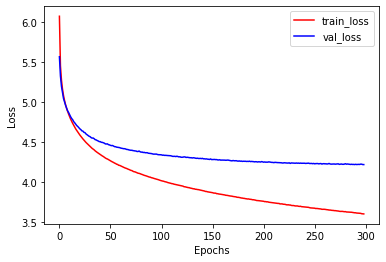

In [142]:
plt.figure()

plt.plot(train_loss_hist, color='red', label='train_loss')
plt.plot(val_loss_hist, color='blue', label='val_loss')
# plt.plot(prom_arm_loss, color='green', label='prom_arm_loss')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig(f'img/Loss-{source}-emb_{D_emb}-lstm_{D_lstm}-seed_{SEED}-epochs_{num_epochs}.png')

plt.show()

In [143]:
def print_ix_sentence(sentence):
    print(' '.join(ix_to_w[ix] for ix in sentence.data))

In [144]:
def torch_ix_sentence_to_w(sentence):
    return [ix_to_w[ix] for ix in sentence.data]

In [145]:
print(f"{'x_i':>16}{'x_i':>16}{'x_i':>16}")

             x_i             x_i             x_i


In [146]:
with torch.no_grad():
    # TODO: Armar corpus de prueba para evaluar resultados después de entrenamiento
    for sentence, y in val_data[:10]: 
        print('===================================================')
        pred = model.pred(sentence)
        sent_words = torch_ix_sentence_to_w(sentence) # Input
        y_hat_words = torch_ix_sentence_to_w(pred) # Datos predichos
        y_words = torch_ix_sentence_to_w(y) # Datos reales
        
        print(f"{'x_i':>16}{'y_hat_i':>16}{'y_i':>16}")
        for x_i, y_hat_i, y_i in zip(sent_words, y_hat_words, y_words):
            print(f"{x_i:>16}{y_hat_i:>16}{y_i:>16}")
        print('===================================================\n')

        

             x_i         y_hat_i             y_i
           <BOS>               "          méxico
          méxico            debe           tiene
           tiene             que             que
             que              no           <UNK>
           <UNK>              la             con
             con              la         firmeza
         firmeza               ,               ,
               ,          porque             con
             con              la        dignidad
        dignidad               ,               ,
               ,          porque          exigir
          exigir               ,         respeto
         respeto               ,               y
               y               a             que
             que              se            cese
            cese              al            esta
            esta          guerra       violación
       violación               ,               a
               a              la             los
             los    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no              es
              es              un           parte
           parte              de              de
              de              la              la
              la           gente      propaganda
      propaganda               y              en
              en              el          contra
          contra              de         nuestra
         nuestra          nación               ,
               ,              no        nosotros
        nosotros               y           <UNK>
           <UNK>               ,           mucho
           mucho               ,               a
               a             los             los
             los      ciudadanos     empresarios
     empresarios               ,              de
              de          méxico          méxico
          méxico               ,               ,
               ,    

In [147]:
torch.save(
    model.state_dict(), # El último
    f'./modelsaves/modelv2-{source}-emb_{D_emb}-lstm_{D_lstm}-seed_{SEED}-epochs_{num_epochs}-last-trained'
)

torch.save(
    best_model, 
    f'./modelsaves/modelv2-{source}-emb_{D_emb}-lstm_{D_lstm}-seed_{SEED}-epochs_{best_val_epoch}-best-val'
)